# Convolutional neural networks for artistic style transfer

In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


## Load and preprocess the content and style images

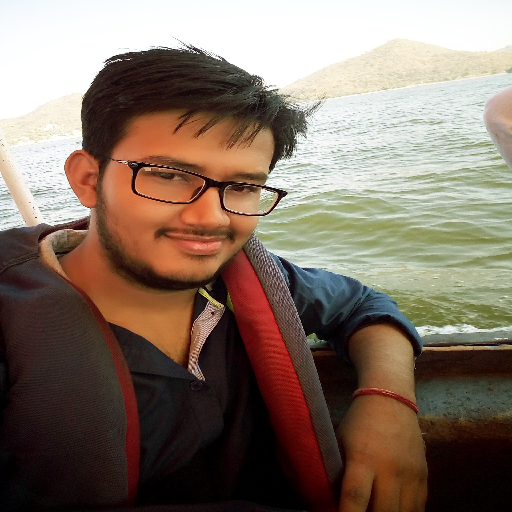

In [2]:
height = 512
width = 512

content_image_path = 'images/me.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

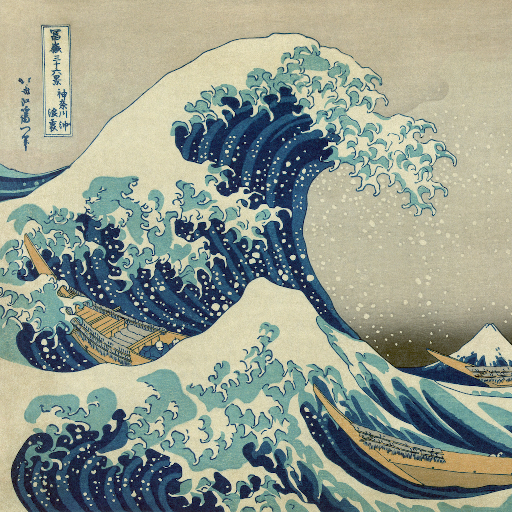

In [3]:
style_image_path = 'images/styles/wave.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

Then, we convert these images into a form suitable for numerical processing. In particular, we add another dimension (beyond the classic height x width x 3 dimensions) so that we can later concatenate the representations of these two images into a common data structure.

In [4]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


For this, we need to perform two transformations:

1. Subtract the mean RGB value (computed previously on the [ImageNet training set](http://image-net.org) and easily obtainable from Google searches) from each pixel.
2. Flip the ordering of the multi-dimensional array from *RGB* to *BGR* (the ordering used in the paper).

In [5]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [6]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Finally, we concatenate all this image data into a single tensor that's suitable for processing by Keras' VGG16 model.

In [7]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

## Reuse a model pre-trained for image classification to define loss functions

In [8]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [9]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_1:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_2:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_3:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'MaxPool_1:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_4:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_5:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_6:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'MaxPool_2:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_7:0' shape=(3, 64, 64, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_8:0' shape=(3, 64, 64, 512) dtype=float32>,
 'block4_conv3': <tf.Tensor 'Relu_9:0' shape=(3

In [10]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

We'll now use the feature spaces provided by specific layers of our model to define these three loss functions. We begin by initialising the total loss to 0 and adding to it in stages.

In [11]:
loss = backend.variable(0.)

### The content loss
The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

In [12]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

### The style loss

For the style loss, we first define something called a *Gram matrix*. The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. By only capturing these aggregate statistics across the image, they are blind to the specific arrangement of objects inside the image. This is what allows them to capture information about style independent of content. (This is not trivial at all, and I refer you to [a paper that attempts to explain the idea](https://arxiv.org/abs/1606.01286).)

The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.


In [13]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

The style loss is then the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images.

In [14]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### The total variation loss

If you were to solve the optimisation problem with only the two loss terms we've introduced so far (style and content), you'll find that the output is quite noisy. We thus add another term, called the [total variation loss](http://arxiv.org/abs/1412.0035) (a regularisation term) that encourages spatial smoothness.

In [15]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

## Define needed gradients and solve the optimisation problem

In [16]:
grads = backend.gradients(loss, combination_image)

In [17]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Now we're finally ready to solve our optimisation problem. This combination image begins its life as a random collection of (valid) pixels, and we use the [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon it.

We stop after 10 iterations because the output looks good to me and the loss stops reducing significantly.

In [18]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 7.60155e+10
Iteration 0 completed in 25s
Start of iteration 1
Current loss value: 4.35157e+10
Iteration 1 completed in 20s
Start of iteration 2
Current loss value: 3.33446e+10
Iteration 2 completed in 21s
Start of iteration 3
Current loss value: 2.96801e+10
Iteration 3 completed in 21s
Start of iteration 4
Current loss value: 2.82843e+10
Iteration 4 completed in 21s
Start of iteration 5
Current loss value: 2.74683e+10
Iteration 5 completed in 21s
Start of iteration 6
Current loss value: 2.69931e+10
Iteration 6 completed in 21s
Start of iteration 7
Current loss value: 2.66853e+10
Iteration 7 completed in 21s
Start of iteration 8
Current loss value: 2.64769e+10
Iteration 8 completed in 22s
Start of iteration 9
Current loss value: 2.63277e+10
Iteration 9 completed in 22s


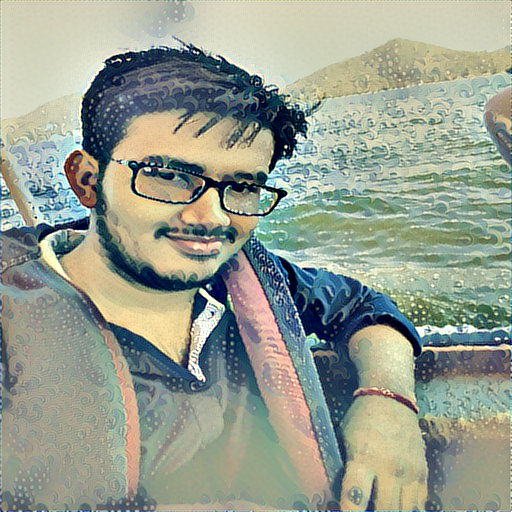

In [19]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)